In [1]:
import numpy as np
import pickle
from scipy.spatial.distance import cosine
import scipy
from numpy import linalg as LA
import random
from tqdm import tqdm
import sys
import argparse
from scipy.stats import pearsonr,spearmanr,percentileofscore
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import operator
import sys
import pdb
from os.path import join
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import spacy

In [65]:
source =  ['evans_even_sample_phrase_'] #['evans_even_sample_']  #['evans_source_','founders_source_']
time_period = ['1640_1720','1730_1810'] #['1700_1810'] 
files = [s+t for s in source for t in time_period]
fnames = [join('data','cofea_full','range_data',x) for x in files]

In [3]:
# Load the w2vec model
def load_embeddings_from_np(filename):
    # load word embedding file and vocab file from file_prefix
    print('loading %s'%filename)
    with open(filename + '.vocab', 'r') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')
    
    # filter out terms
    filtered_vocab = [word for word in vocab if special_filter.match(word) is None]
    filtered_w2i = {}
    filtered_wv = []
    for i,word in enumerate(filtered_vocab):
        filtered_wv.append(wv[w2i[word]])
        filtered_w2i[word] = i
        
    vocab = filtered_vocab
    wv = filtered_wv
    w2i = filtered_w2i
    
    return vocab, wv, w2i

def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

def load_and_normalize(lang, filename, vocab, wv, w2i):
    # load word embeddings, vocab file and update the global maps (vocab, wv, w2i)

    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)

    # normalize the word embeddings
    wv_muse = normalize(wv_muse)

    # update the global maps
    vocab[lang] = vocab_muse
    wv[lang] = wv_muse
    w2i[lang] = w2i_muse
    print('loaded and normalized %s embeddings'%filename)
    
def align(w2i, wv, vocab, space1, space2, aligned):
    # align the word embeddings from two spaces using orthogonal procrustes (OP)

    # identify the common words in both spaces
    train_words = list(set(vocab[space1]).intersection(set(vocab[space2])))
    
    # perform OP
    num = len(train_words)
    mat_bef = np.zeros((num, 300))
    mat_aft = np.zeros((num, 300))
    for i, w in enumerate(train_words):
        mat_bef[i, :] = wv[space1][w2i[space1][w]]
        mat_aft[i, :] = wv[space2][w2i[space2][w]]
    Q_bef, s_bef = scipy.linalg.orthogonal_procrustes(mat_bef, mat_aft)
    
    # update the global maps
    create_aligned(w2i, wv, vocab, Q_bef, space1, aligned)

    # normalize the aligned embeddings
    wv[aligned] = normalize(wv[aligned])
    
def create_aligned(w2i, wv, vocab, Q_bef, space1, aligned):
    # update the global maps with the aligned vectors, vocab and word to sequence id mapping
    wv[aligned] = np.zeros(wv[space1].shape)
    for i, vec in enumerate(wv[space1]):
        wv[aligned][i, :] = np.dot(vec, Q_bef)
    vocab[aligned] = vocab[space1]
    w2i[aligned] = w2i[space1]

    
def load_all_embeddings(name_a,name_b,embed_a,embed_b):
    # loads embedding from both spaces and performs alignment
    vocab = {}
    wv = {}
    w2i = {}
    load_and_normalize(name_a, embed_a, vocab, wv, w2i)
    load_and_normalize(name_b, embed_b, vocab, wv, w2i)
    align(w2i, wv, vocab, name_a, name_b, name_a+'_a')
    return vocab, wv, w2i



In [4]:
def extract_freqs(filename, vocab):
    # extract word raw frequencies and normalized frequencies

    # raw counts
    print('extracting freqs %s'%filename)
    count = defaultdict(int)
    with open(filename, 'r') as f:
        for l in f:
            for w in l.strip().split():
                count[w] += 1

    # consider only words in the vocabulary
    count_vocab = defaultdict(int)
    for w in vocab:
        if w in count:
            count_vocab[w] = count[w]

    # normalized frequencies
    tot = sum([count_vocab[item] for item in count_vocab])
    freq_norm = defaultdict(int)
    for w in count_vocab:
        freq_norm[w] = count_vocab[w] / float(tot)

    # top-frequent
    top_freq = defaultdict(int)
    sorted_words = [x[0] for x in sorted(count_vocab.items(), key=operator.itemgetter(1))]
    cutoff = len(sorted_words) / float(20)
    top_freq_words = sorted_words[int(4 * cutoff):-200]  # -int(cutoff)]
    for w in top_freq_words:
        top_freq[w] = count[w]

    print('done')
    return freq_norm, count_vocab, top_freq

In [5]:
def topK(w, space, k=10, count = None, min_freq = 0):
    # identify the top k neighbors of a word in a space

    # extract the word vector for word w
    idx = w2i[space][w]
    vec = wv[space][idx, :]

    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)

    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    if count:
        # consider only the neighbors whose raw frequency is greater than min_freq
        best = []
        for i in sort_sim:
            if i != idx and count[vocab[space][i]] > min_freq:
                best.append(i)
                if len(best) == k:
                    break
    else:
        best = sort_sim[:(k + 1)]

    return [vocab[space][i] for i in best if i != idx]

def NN_scores(space1, sapce2, freq1, freq2, count1, count2,K,MIN_COUNT,s_words,t_words):
    # rank all the words based on our method  
    # compute nearest neighbors overlap for all the common words
    nn_scores = []
    # ignore punctuation and other problem terms in the spaces
    pbar = tqdm(total=len(vocab[space1]))
    for i, w in enumerate(vocab[space1]):
        if w not in s_words and w in freq1  and w in freq2:
            if count1[w] > MIN_COUNT and count2[w] > MIN_COUNT or w in t_words:
                neighbors_bef = set(topK(w, space1, K, count1, 100))
                neighbors_aft = set(topK(w, sapce2, K, count2, 100))
                nn_scores.append((len(neighbors_bef.intersection(neighbors_aft)), w))
        if i%10 == 0:
            pbar.update(10)
    pbar.close()
    print('len of ranking', len(nn_scores))

    # rank these words
    nn_scores_sorted = sorted(nn_scores)
    return nn_scores_sorted


def cosdist_scores(space1, space2, freq1, freq2, count1, count2,MIN_COUNT,s_words,t_words):
    # compute cosine similarity for common words and sort these words from low similarity to high

    # compute cosine similarity for common words
    all_scores = []
    pbar = tqdm(total=len(vocab[space1]))
    for i, w in enumerate(vocab[space1]):
        if w not in s_words and w in freq1 and w in freq2:
            if count1[w] > MIN_COUNT and count2[w] > MIN_COUNT or w in t_words:
                all_scores.append((np.inner(wv[space1][w2i[space1][w], :], wv[space2][w2i[space2][w], :]), w))
        if i%10 == 0:
            pbar.update(10)
    pbar.close()
    print('len of ranking', len(all_scores))

    # rank these words
    all_scores_sorted = sorted(all_scores)
    return all_scores_sorted


In [6]:
def diff_nn(w, count1, count2, MIN_COUNT,K):
    # identify top 10 neighbors that are specific in a space

    # identify the neighbors 
    nn1 = topK(w, val1, K, count1, MIN_COUNT)
    nn2 = topK(w, val2, K, count2, MIN_COUNT)

    # identify the top 10 neighbors that specific to a space
    top_diff1 = []
    top_diff2 = []
    for w in nn1:
        if w not in nn2:
            top_diff1.append(w)
            if len(top_diff1) == 10:
                break
    for w in nn2:
        if w not in nn1:
            top_diff2.append(w)
            if len(top_diff2) == 10:
                break
    return top_diff1, top_diff2

In [93]:
MIN_COUNT = 200 # default 200
K = 1000 #default 1000
freq_thr = .00001 # default .00001
s_words = set(stopwords.words('french'))
top_k = 10 #default top k different value
special_filter = re.compile('.*(•|∣|\W|\d).*|^\w\.?$')
nlp = spacy.load("en_core_web_sm")
#special_filter = re.compile('a^')# match with nothing for now

# get all terms in the constitution
with open(join('data','constitution_words.txt'), 'r',encoding = 'utf-8') as f:
    target_words = f.read().splitlines()

# name_a,name_b,embed_a,embed_b
val1 = files[0] # time_period[0]
val1fname = fnames[0]
val2 = files[1]# time_period[1]
val2fname = fnames[1]

vocab, wv, w2i = load_all_embeddings(val1,val2,
                                    val1fname,val2fname)

# extract frequencies
freq_norm_val1, count_vocab_val1, top_freq_val1 = extract_freqs(
    val1fname+'.txt', vocab[val1])

freq_norm_val2, count_vocab_val2, top_freq_val2 = extract_freqs(
    val2fname+'.txt', vocab[val2])


loading data/cofea_full/range_data/evans_even_sample_phrase_1640_1720
loaded and normalized data/cofea_full/range_data/evans_even_sample_phrase_1640_1720 embeddings
loading data/cofea_full/range_data/evans_even_sample_phrase_1730_1810
loaded and normalized data/cofea_full/range_data/evans_even_sample_phrase_1730_1810 embeddings
extracting freqs data/cofea_full/range_data/evans_even_sample_phrase_1640_1720.txt
done
extracting freqs data/cofea_full/range_data/evans_even_sample_phrase_1730_1810.txt
done


In [94]:
# detect words using nn
print('detecting words using NN ...')
nn = NN_scores(val1 + '_a', val2, top_freq_val1, top_freq_val2, count_vocab_val1,
                        count_vocab_val2,K,MIN_COUNT,s_words,target_words)
print('done.')    

  0%|          | 0/31649 [00:00<?, ?it/s]

detecting words using NN ...


31650it [04:26, 118.69it/s]                            

len of ranking 4770
done.


In [95]:
for w_nn in  nn[:5]:
    top_diff1, top_diff2 = diff_nn(w_nn[1], count_vocab_val1, count_vocab_val2, MIN_COUNT,K)
    print(w_nn[1],end = '\t')
    print(val1 + ' ' + str(count_vocab_val1[w_nn[1]]) + '\t' + val2 + ' ' + str(count_vocab_val2[w_nn[1]]))
    for word in top_diff1:
        print(word,end='\t')
        print(count_vocab_val1[word],end='\t')
    print('\n')
    for word in top_diff2:
        print(word,end='\t')
        print(count_vocab_val2[word],end='\t')
    print('\n')

miss	evans_even_sample_phrase_1640_1720 447	evans_even_sample_phrase_1730_1810 9653
lose	1251	obtain	1721	attain	599	fail	1177	blessedness	897	arrive	346	reap	320	accomplish	359	felicity	451	partake	719	

milner	466	woodley	490	harriet	773	lady	14606	harriot	532	eliza	1253	fanny	1065	lucy	725	sophia	1082	juliet	279	

count	evans_even_sample_phrase_1640_1720 860	evans_even_sample_phrase_1730_1810 4504
reckon	425	approve	668	loath	214	allow	1311	indulge	310	render	1662	prefer	237	imagine	700	deserve	747	finde	562	

marquis	2609	duke	3551	countess	1140	marchioness	581	baron	1927	chevalier	557	baroness	346	isidor	214	alphonso	849	mademoiselle	493	

carriages	evans_even_sample_phrase_1640_1720 234	evans_even_sample_phrase_1730_1810 697
practices	652	actions	2168	behaviour	709	vicious	287	speeches	293	inclinations	334	dealings	384	performances	255	conversation	1540	dealing	420	

carts	230	waggons	493	coaches	249	horses	4510	chairs	353	baggage	670	mules	298	mortars	218	axes	213	pounders	215	


In [96]:
# detect words using cosdist
print('detecting words using cosdist ...')
cosdist = cosdist_scores(val1 + '_a', val2, top_freq_val1, top_freq_val2, count_vocab_val1,
                       count_vocab_val2,MIN_COUNT,s_words,target_words)

  0%|          | 0/31649 [00:00<?, ?it/s]

detecting words using cosdist ...


31650it [00:00, 60613.46it/s]                           

len of ranking 4770


In [97]:
pic_name = 'evans_even_sample_phrase' #'evans_even_sample' #'evans_founders_source'

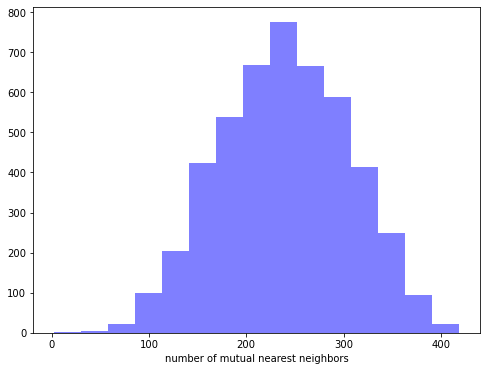

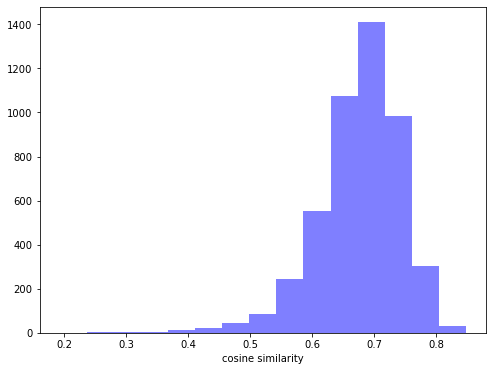

In [98]:
# Visualize the scores
# histogram for number of common neighbors 
# get scores only
nn_scores = [x for x,y in nn]
num_bins = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('number of mutual nearest neighbors')
n, bins, patches = ax.hist(nn_scores, num_bins, facecolor='blue', alpha=0.5)
# plt.title(r' Number of Mutual Nearest Neigbors Histogram for Freuency')
plt.savefig(pic_name+'_nn_hist')

# histogram for cosine scores
cos_scores = [x for x,y in cosdist ]
num_bins = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('cosine similarity')
n, bins, patches = ax.hist(cos_scores, num_bins, facecolor='blue', alpha=0.5)
plt.savefig(pic_name +'_cos_hist')

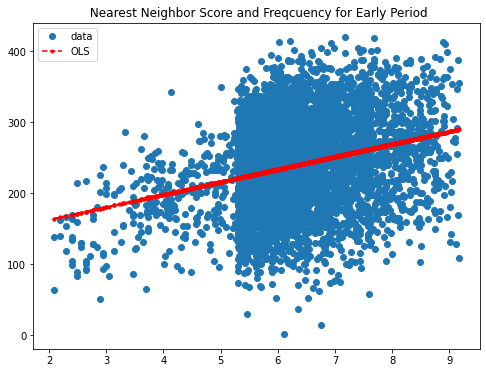

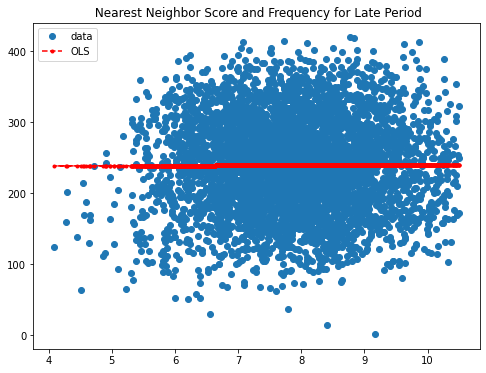

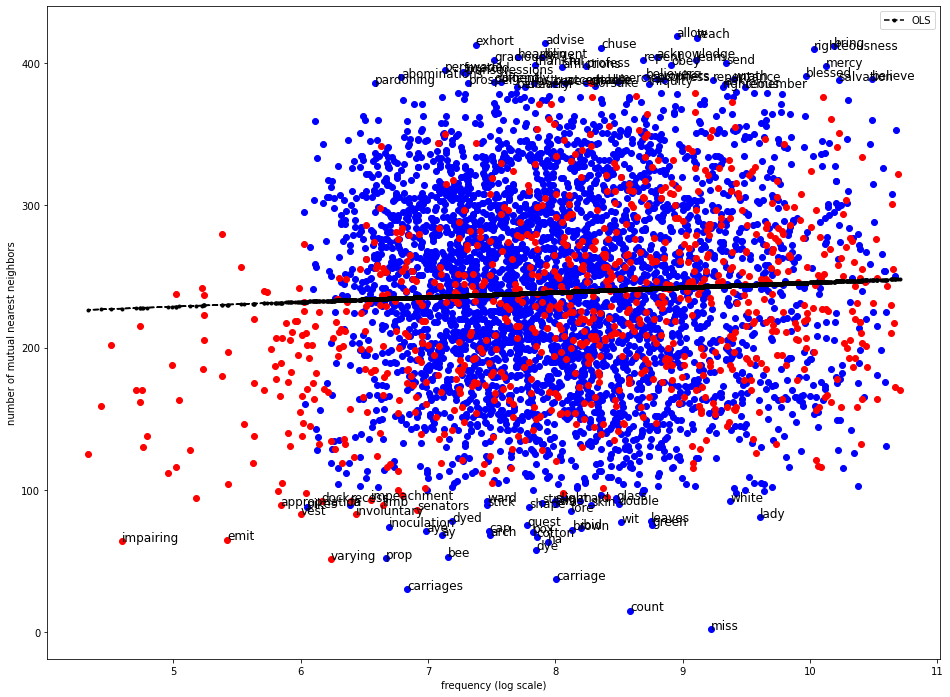

In [99]:
# scatterplot of scores to frequencies
# nn
nn_words = [y for x,y in nn]
nn_freq_1 = np.log([count_vocab_val1[y] for x,y in nn])
model = sm.OLS(nn_scores, sm.add_constant(nn_freq_1))
results = model.fit()

fig, ax = plt.subplots(figsize=(8,6))
plt.title(r' Nearest Neighbor Score and Freqcuency for Early Period')
ax.plot(nn_freq_1, nn_scores, 'o', label="data")
ax.plot(nn_freq_1,results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')

nn_freq_2 = np.log([count_vocab_val2[y] for x,y in nn])
model = sm.OLS(nn_scores, sm.add_constant(nn_freq_2))
results = model.fit()
fig, ax = plt.subplots(figsize=(8,6))
plt.title(r' Nearest Neighbor Score and Frequency for Late Period')
ax.plot(nn_freq_2, nn_scores, 'o', label="data")
ax.plot(nn_freq_2,results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')

#nn_diff = [count_vocab_val2[y]-count_vocab_val1[y] for x,y in nn]
#plt.scatter(nn_diff,nn_scores,alpha=.5)
#plt.title(r' Nearest Neighbor Score and Freqcuency Difference')
#plt.show()

# total frequency across both data sets
nn_freq_tot = np.log([count_vocab_val1[y]+ count_vocab_val2[y] for x,y in nn])
model = sm.OLS(nn_scores, sm.add_constant(nn_freq_tot))
results = model.fit()
fig, ax = plt.subplots(figsize=(16,12))
#plt.title(r' Nearest Neighbor Score and Frequency for Both Periods')
#ax.plot(nn_freq_tot, nn_scores, 'o', label="data")
ax.plot(nn_freq_tot,results.fittedvalues, 'k--.', label="OLS")
ax.legend(loc='best')

top = np.percentile(nn_scores,99)
bottom = np.percentile(nn_scores,1)
bottom_five = np.percentile(nn_scores,1)
target_x = []
target_y = []
x = []
y = []
for i, word in enumerate(nn_words):
    if word in target_words:
        target_x.append(nn_freq_tot[i])
        target_y.append(nn_scores[i])
    else:
        x.append(nn_freq_tot[i])
        y.append(nn_scores[i])
        
ax.scatter(x, y,color ='blue')        
ax.scatter(target_x, target_y,color ='red')
ax.set_ylabel('number of mutual nearest neighbors')
ax.set_xlabel('frequency (log scale)')
top_nn_target = []
for i, word in enumerate(nn_words):
    if nn_scores[i] >= top or nn_scores[i] <= bottom:
        ax.annotate(word, (nn_freq_tot[i], nn_scores[i]),fontsize=12)
    if word in target_words and nn_scores[i] <= bottom_five:
        top_nn_target.append(word)
plt.savefig(pic_name+'_nn_freq')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     1332.
Date:                Thu, 02 Sep 2021   Prob (F-statistic):          2.29e-257
Time:                        13:04:28   Log-Likelihood:                 6669.8
No. Observations:                4770   AIC:                        -1.334e+04
Df Residuals:                    4768   BIC:                        -1.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4850      0.005     91.697      0.0

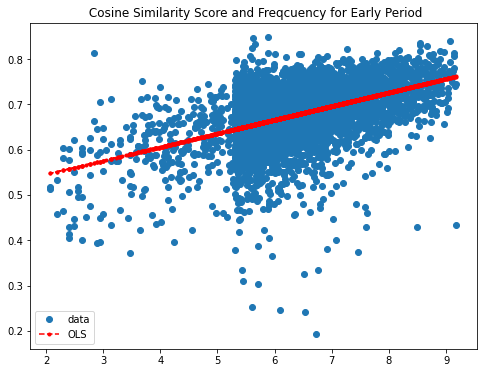

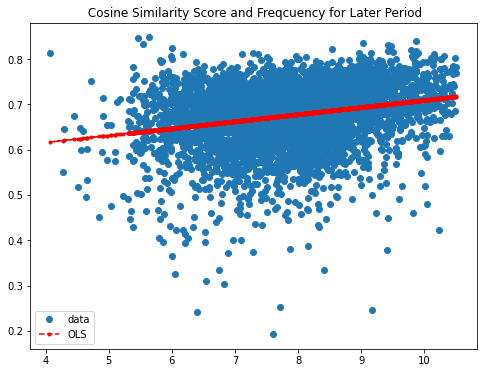

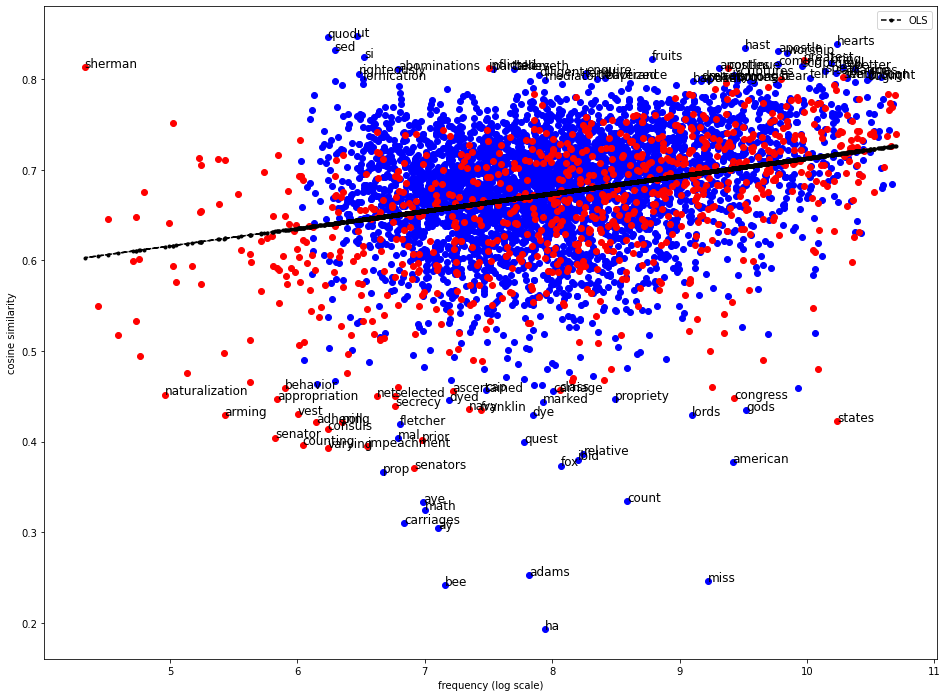

In [100]:
# scatterplot of scores to frequencies
# cos
cos_words = [y for x,y in cosdist]
cos_freq_1 = np.log([count_vocab_val1[y] for x,y in cosdist])
model = sm.OLS(cos_scores, sm.add_constant(cos_freq_1))
results = model.fit()
fig, ax = plt.subplots(figsize=(8,6))
plt.title(r' Cosine Similarity Score and Freqcuency for Early Period')
ax.plot(cos_freq_1, cos_scores, 'o', label="data")
ax.plot(cos_freq_1,results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')
print(results.summary())


cos_freq_2 = np.log([count_vocab_val2[y] for x,y in cosdist])
model = sm.OLS(cos_scores,sm.add_constant(cos_freq_2))
results = model.fit()
fig, ax = plt.subplots(figsize=(8,6))
plt.title(r' Cosine Similarity Score and Freqcuency for Later Period')
ax.plot(cos_freq_2, cos_scores, 'o', label="data")
ax.plot(cos_freq_2,results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')

#cos_diff = [count_vocab_val2[y]-count_vocab_val1[y] for x,y in cosdist]
#plt.scatter(cos_diff,cos_scores,alpha=.5)
#plt.title(r' Cosine Similarity Score and Freqcuency Difference')
#plt.show()

cos_freq_tot = np.log([ count_vocab_val1[y] + count_vocab_val2[y] for x,y in cosdist])
model = sm.OLS(cos_scores,sm.add_constant(cos_freq_tot))
results = model.fit()
fig, ax = plt.subplots(figsize=(16,12))
#plt.title(r' Cosine Similarity Score and Freqcuency for Both Periods')
#ax.plot(cos_freq_tot, cos_scores, 'o', label="data")
ax.plot(cos_freq_tot,results.fittedvalues, 'k--.', label="OLS")
ax.legend(loc='best')
top = np.percentile(cos_scores,99)
bottom = np.percentile(cos_scores,1)
bottom_five = np.percentile(cos_scores,1)
target_x = []
target_y = []
x = []
y = []
for i, word in enumerate(cos_words):
    if word in target_words:
        target_x.append(cos_freq_tot[i])
        target_y.append(cos_scores[i])
    else:
        x.append(cos_freq_tot[i])
        y.append(cos_scores[i])
        
ax.scatter(x, y,color ='blue')        
ax.scatter(target_x, target_y,color ='red')
top_cos_target = []
ax.set_ylabel('cosine similarity')
ax.set_xlabel('frequency (log scale)')
for i, word in enumerate(cos_words):
    if cos_scores[i] >= top or cos_scores[i] <= bottom:
        ax.annotate(word, (cos_freq_tot[i], cos_scores[i]),fontsize=12)
    if word in target_words and cos_scores[i] <= bottom_five:
        top_cos_target.append(word)
plt.savefig(pic_name+'_cos_freq')

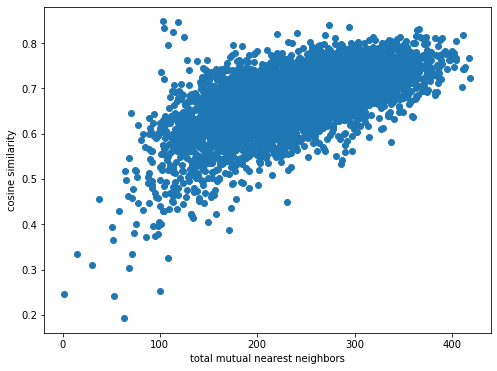

In [101]:
# Compare cosine score to nearest neighbor
scores = {}
for score,word in nn:
    scores[word] = [score]
for score,word in cosdist:
    scores[word].append(score)
x = []
y = []
words = []
for word in scores:
    words.append(word) #may want a tick
    x.append(scores[word][0]) #nn
    y.append(scores[word][1]) #cos

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y)

ax.set_ylabel('cosine similarity')
ax.set_xlabel('total mutual nearest neighbors')

#for i, word in enumerate(words):
#    plt.annotate(word, (x[i], y[i]))

# add terms of interest scores as seperately colored dots
plt.savefig(pic_name+'_nn_cos_comparison')

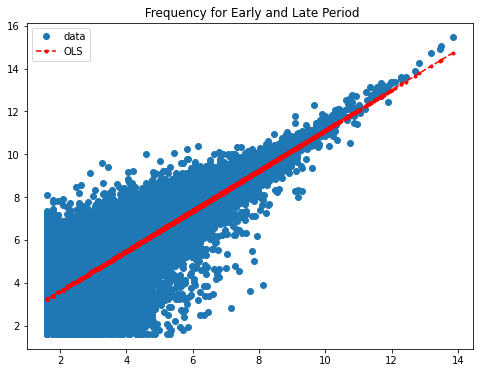

In [102]:
# early frequency to late frequency
early = []
late = []

for word in count_vocab_val1:
    if word in count_vocab_val2:
        early.append(count_vocab_val1[word])
        late.append(count_vocab_val2[word])

early = np.log(early)
late = np.log(late)
model = sm.OLS(late,sm.add_constant(early))
results = model.fit()
fig, ax = plt.subplots(figsize=(8,6))
plt.title(r' Frequency for Early and Late Period')
ax.plot(early, late, 'o', label="data")
ax.plot(early,results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')

In [103]:
# part of speech and score
pos = []
for  word in scores:
    doc = nlp(word)
    pos.append(doc[0].pos_)
    
pos = set(pos)
color_key = {}
for i,p in enumerate(pos):
    color_key[p] = i
    
for word in scores:
    doc = nlp(word)
    scores[word].append(color_key[doc[0].pos_])

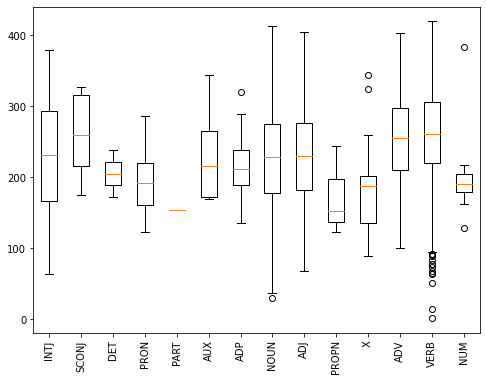

In [104]:
# box plots broken out by parts of speech
pos_data = [[] for _ in range(len(pos))]
for word in scores:
    pos_data[scores[word][2]].append(scores[word][0])
    
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(pos_data)
plt.xticks([i +1 for i in range(len(pos))], pos, rotation='vertical')
plt.savefig(pic_name+'_nn_pos_distribution')

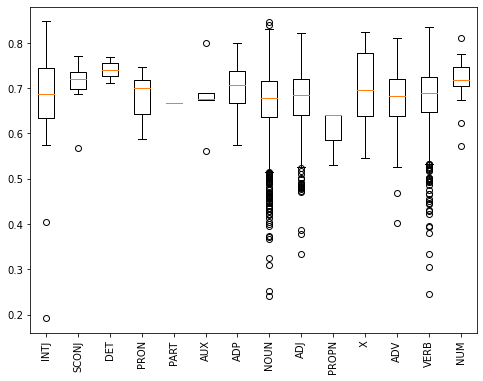

In [105]:
pos_data = [[] for _ in range(len(pos))]
for word in scores:
    pos_data[scores[word][2]].append(scores[word][1])

fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(pos_data)
plt.xticks([i+1 for i in range(len(pos))], pos, rotation='vertical')
plt.savefig(pic_name+'_cos_pos_distribution')

In [106]:
# get the percentile of scores
target_scores = {}
nn_target = []
cos_target = []
total = 0
for word in target_words:
    if word in scores:
        target_scores[word] = scores[word]
        nn_target.append((percentileofscore(nn_scores,scores[word][0]),word))
        cos_target.append((percentileofscore(cos_scores,scores[word][1]),word))

In [107]:
nn_target.sort(key = lambda tup: tup[0])
cos_target.sort(key = lambda tup: tup[0])

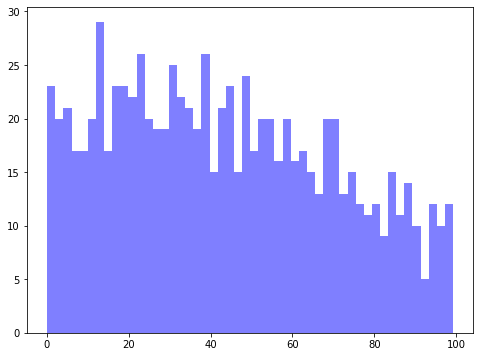

In [108]:
nn_target_percentiles = [x for x,y in nn_target]
num_bins = 50
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(nn_target_percentiles, num_bins, facecolor='blue', alpha=0.5)
plt.show()

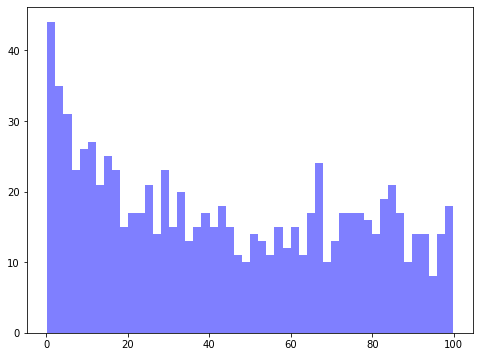

In [109]:
cos_target_percentiles = [x for x,y in cos_target]
num_bins = 50
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(cos_target_percentiles, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [110]:
set.intersection(set(top_nn_target),set(top_cos_target))

{'appropriation', 'impeachment', 'senators', 'varying', 'vest'}

In [111]:
for w_nn in  set(top_cos_target):
    top_diff1, top_diff2 = diff_nn(w_nn, count_vocab_val1, count_vocab_val2, MIN_COUNT,K)
    print(w_nn,end = '\t')
    print(val1 + ' ' + str(count_vocab_val1[w_nn]) + '\t' + val2 + ' ' + str(count_vocab_val2[w_nn]))
    for word in top_diff1:
        print(word,end='\t')
        print(count_vocab_val1[word],end='\t')
    print('\n')
    for word in top_diff2:
        print(word,end='\t')
        print(count_vocab_val2[word],end='\t')
    print('\n')

appropriation	evans_even_sample_phrase_1640_1720 12	evans_even_sample_phrase_1730_1810 333
supernatural	233	covenanting	260	distinguishing	316	bestows	204	ministerial	327	qualifications	509	superior	247	internal	266	soveraignty	210	attribute	247	

repealing	261	payment	3422	stipulation	532	fund	1404	levying	480	requisitions	354	taxation	904	funds	1090	enacting	217	repeal	1069	

behavior	evans_even_sample_phrase_1640_1720 9	evans_even_sample_phrase_1730_1810 358
expences	201	cler	206	disorders	247	managing	259	industry	321	commerce	287	judicature	267	carriages	234	abilities	307	promoting	284	

deportment	878	affability	250	affable	238	inferiors	320	frankness	361	rudeness	327	decorum	514	inconstancy	210	civilities	247	levity	644	

vest	evans_even_sample_phrase_1640_1720 12	evans_even_sample_phrase_1730_1810 393
governed	249	govern	480	ruled	311	cler	206	lordship	275	commissioner	263	sovereignty	231	superior	247	wronged	253	acquaint	318	

invest	332	robe	733	robes	817	vested	1791	plumes	2

In [112]:
top_cos_target

['senators',
 'varying',
 'impeachment',
 'counting',
 'prior',
 'senator',
 'consuls',
 'adhering',
 'poll',
 'states',
 'arming',
 'vest',
 'franklin',
 'navy',
 'secrecy',
 'appropriation',
 'congress',
 'selected',
 'net',
 'naturalization',
 'ascertained',
 'class',
 'behavior']

In [113]:
top_nn_target

['varying',
 'impairing',
 'emit',
 'involuntary',
 'vest',
 'senators',
 'appropriation',
 'limb',
 'dock',
 'recess',
 'impeachment']

In [114]:
# unigram
interest_words = ['natural','born','citizen','commerce','bank','capital','bear','arms','violence']
for word in interest_words:
    print(word)
    print('nn score: '+ str(scores[word][0]),end='\t')
    print('nn percentile: '+ str(percentileofscore(nn_scores,scores[word][0])),end='\t')
    print('cos score: '+ str(scores[word][1]),end='\t')
    print('cos percentile: '+ str(percentileofscore(cos_scores,scores[word][1]))+'\n')

natural
nn score: 178	nn percentile: 19.266247379454928	cos score: 0.6325267042651768	cos percentile: 21.27882599580713

born
nn score: 234	nn percentile: 46.498951781970646	cos score: 0.6792604784501088	cos percentile: 47.0020964360587

citizen
nn score: 146	nn percentile: 8.385744234800839	cos score: 0.46988911806425626	cos percentile: 1.278825995807128

commerce
nn score: 188	nn percentile: 23.071278825995808	cos score: 0.65136102424408	cos percentile: 30.062893081761008

bank
nn score: 182	nn percentile: 20.754716981132077	cos score: 0.618287194089338	cos percentile: 16.81341719077568

capital
nn score: 95	nn percentile: 1.079664570230608	cos score: 0.46789038573161834	cos percentile: 1.2368972746331237

bear
nn score: 343	nn percentile: 93.99371069182389	cos score: 0.8003039455451195	cos percentile: 99.22431865828092

arms
nn score: 164	nn percentile: 13.941299790356394	cos score: 0.6950069017696303	cos percentile: 57.505241090146754

violence
nn score: 191	nn percentile: 24.50733

In [119]:
# bigram
interest_words = ['necessaryandproper']#'cruelandunusual','naturalborn','necessaryandproper','publicuse'
for word in interest_words:
    print(word)
    print('nn score: '+ str(scores[word][0]),end='\t')
    print('nn percentile: '+ str(percentileofscore(nn_scores,scores[word][0])),end='\t')
    print('cos score: '+ str(scores[word][1]),end='\t')
    print('cos percentile: '+ str(percentileofscore(cos_scores,scores[word][1]))+'\n')

necessaryandproper


KeyError: 'necessaryandproper'